# Plot downstream LOSO results

## Imports and Functions

In [1]:
import os
import cmat
import pickle
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
plt.style.use('seaborn-v0_8')

def get_summarized_results(res_to_plot, combined_classes=None):
    summed_cmats = {}
    norm_summed_cmats = {}
    results = {}
    activity_results = {}
    CV_res = {}
    for model_name, res_dict in res_to_plot.items():
        res_path = res_dict['res_path']
        res_folds = res_dict['folds'] if 'folds' in res_dict else None
        fold_cmats = {}
        _summed_cmats = []
        subj_cmat_names = [x for x in os.listdir(res_path) if 'best_args' not in x]
        for subj_cmat_name in subj_cmat_names:
            with open(os.path.join(res_path,subj_cmat_name), 'rb') as f:
                pickle_file = pickle.load(f)
                if len(pickle_file)==3:
                    _args, _cmats, _sids = pickle_file 
                else:
                    _args, _cmats = pickle_file
                    _sids = range(len(_cmats))
                ################################################################
                if combined_classes:
                    #print(f'DO CLASS REPLACEMENT WITH: {combined_classes}')
                    _new_cmats = {}
                    _sids = [item for row in _sids for item in row] if type(_sids[0])==list else _sids
                    cmat_iterator = _cmats.items() if type(_cmats)==dict else zip(_sids,_cmats)
                    for _sid, _c in cmat_iterator:
                        new_cm_df = _c.cmat.copy()
                        for new_cl, classes in combined_classes.items():
                            if not all([c in new_cm_df.columns for c in classes]):
                                #print(f'{classes} not in cmats. Pass...')
                                continue
                            new_cm_df.loc[new_cl] = new_cm_df.loc[classes].sum()
                            new_cm_df[new_cl] = new_cm_df[classes].sum(axis=1)
                            classes_to_remove = classes.copy()
                            try:
                                classes_to_remove.remove(new_cl)
                            except ValueError:
                                pass
                            new_cm_df = new_cm_df.drop(classes_to_remove,axis=1)
                            new_cm_df = new_cm_df.drop(classes_to_remove,axis=0)
                        _new_cmats[_sid] = cmat.ConfusionMatrix(new_cm_df)
                    _cmats = _new_cmats
                ################################################################
                if type(_cmats)==dict:
                    _summed_cmats += [c for c in _cmats.values()]
                else:
                    _summed_cmats += _cmats
            if res_folds:
                for fold_num, fold_subjects in enumerate(res_folds):
                    if subj_cmat_name.replace('_cmat.pkl','') in fold_subjects:
                        if fold_num not in fold_cmats:
                            fold_cmats[fold_num] = [_cmats]
                        else:
                            fold_cmats[fold_num].append(_cmats)
                CV_res[model_name] = {
                    'MeanCVF1': np.mean([np.mean([list(x.values())[0].average_f1score for x in fold_cmats[y]]) for y in fold_cmats]),
                    'StdCVF1':  np.std([np.mean([list(x.values())[0].average_f1score for x in fold_cmats[y]]) for y in fold_cmats]),
                    'MeanCVSensitivity': np.mean([np.mean([list(x.values())[0].average_recall for x in fold_cmats[y]]) for y in fold_cmats]),
                    'StdCVSensitivity':  np.std([np.mean([list(x.values())[0].average_recall for x in fold_cmats[y]]) for y in fold_cmats]),
                    'MeanCVPrecision': np.mean([np.mean([list(x.values())[0].average_precision for x in fold_cmats[y]]) for y in fold_cmats]),
                    'StdCVPrecision':  np.std([np.mean([list(x.values())[0].average_precision for x in fold_cmats[y]]) for y in fold_cmats]),
                    'MeanCVAccuracy': np.mean([np.mean([list(x.values())[0].accuracy for x in fold_cmats[y]]) for y in fold_cmats]),
                    'StdCVAccuracy':  np.std([np.mean([list(x.values())[0].accuracy for x in fold_cmats[y]]) for y in fold_cmats])
                    }
        # Summed cmat
        summed_cmats[model_name] = cmat.ConfusionMatrix(sum(c.cmat for c in _summed_cmats)).cmat
        norm_summed_cmats[model_name] = cmat.ConfusionMatrix(sum(c.cmat for c in _summed_cmats)).normalize(mode='recall').cmat
        # Activity results
        activity_results[model_name] = pd.concat({
            'MeanF1': pd.concat([c.f1score for c in _summed_cmats],axis=1).mean(axis=1),
            'StdF1': pd.concat([c.f1score for c in _summed_cmats],axis=1).std(axis=1),
            'SemF1': pd.concat([c.f1score for c in _summed_cmats],axis=1).sem(axis=1),
            'MinF1': pd.concat([c.f1score for c in _summed_cmats],axis=1).min(axis=1),
            'MaxF1': pd.concat([c.f1score for c in _summed_cmats],axis=1).max(axis=1),
            'MeanSensitivity': pd.concat([c.recall for c in _summed_cmats],axis=1).mean(axis=1),
            'StdSensitivity':  pd.concat([c.recall for c in _summed_cmats],axis=1).std(axis=1),
            'MinSensitivity':  pd.concat([c.recall for c in _summed_cmats],axis=1).min(axis=1),
            'MaxSensitivity':  pd.concat([c.recall for c in _summed_cmats],axis=1).max(axis=1),
            'MeanPrecision': pd.concat([c.precision for c in _summed_cmats],axis=1).mean(axis=1),
            'StdPrecision':  pd.concat([c.precision for c in _summed_cmats],axis=1).std(axis=1),
            'MinPrecision':  pd.concat([c.precision for c in _summed_cmats],axis=1).min(axis=1),
            'MaxPrecision':  pd.concat([c.precision for c in _summed_cmats],axis=1).max(axis=1),
        }, axis=1)
        # Combined actvitities results
        results[model_name] = {
            'MeanF1': np.mean([c.average_f1score for c in _summed_cmats]),
            'StdF1': np.std([c.average_f1score for c in _summed_cmats]),
            'SemF1': stats.sem([c.average_f1score for c in _summed_cmats]),
            'MinF1': np.min([c.average_f1score for c in _summed_cmats]),
            'MaxF1': np.max([c.average_f1score for c in _summed_cmats]),
            'MeanSensitivity': np.mean([c.average_recall for c in _summed_cmats]),
            'StdSensitivity':  np.std([c.average_recall for c in _summed_cmats]),
            'MinSensitivity':  np.min([c.average_recall for c in _summed_cmats]),
            'MaxSensitivity':  np.max([c.average_recall for c in _summed_cmats]),
            'MeanPrecision': np.mean([c.average_precision for c in _summed_cmats]),
            'StdPrecision':  np.std([c.average_precision for c in _summed_cmats]),
            'MinPrecision':  np.min([c.average_precision for c in _summed_cmats]),
            'MaxPrecision':  np.max([c.average_precision for c in _summed_cmats]),
            'MeanAccuracy': np.mean([c.accuracy for c in _summed_cmats]),
            'StdAccuracy':  np.std([c.accuracy for c in _summed_cmats]),
            'MinAccuracy':  np.min([c.accuracy for c in _summed_cmats]),
            'MaxAccuracy':  np.max([c.accuracy for c in _summed_cmats]),
        }
    results = pd.DataFrame(results)
    CV_res = pd.DataFrame(CV_res)
    return results, CV_res, activity_results, summed_cmats, norm_summed_cmats, _summed_cmats

def plot_metrics(res_to_plot, metric='F1', title='', _combine_classes=None):
    res, _, _, _, _, _ = get_summarized_results(res_to_plot, combined_classes=_combine_classes)
    res.T.plot(kind='bar',y=f'Mean{metric}',yerr=f'Std{metric}', title=title)

def specificity(_cmat):
    cmat_arr = _cmat.cmat.values
    TN = cmat_arr[0,0]
    FP = cmat_arr[0,1]
    return TN/(TN+FP)

def sensitivity(_cmat):
    cmat_arr = _cmat.cmat.values
    TP = cmat_arr[1,1]
    FN = cmat_arr[1,0]
    return TP/(TP+FN)

# Background for confusion matrix
fig_facecolor = '#ffffff'

# Heatmap colors for plotting
#heatmapss = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r']
heatmap_cmap = 'Blues_r'
heatmap_edge_color = '#f7f7f7'
# Font color
heatmap_font_color = 'k'

# Try to get the matplotlib pyplot object, handle import error
def pyplot():
    try:
        import matplotlib.pyplot as plt 
        return plt
    except ImportError:
        raise ImportError( 'Could not get pyplot object: matplotlib is not installed' )

def plot(selfcmat, ax=None, title=None, plot_text=None, savefig=False, normalize_cmat=True,
         colorbar=True, ylabel=True, xlabel=True,figg=None, axx=None, dropna=False):
    '''
    Plot a confusiono matrix 
    '''
    plt = pyplot()
    plt.rcParams.update({'font.size': 18})
    plt.rc('axes', labelsize=18)     # fontsize of the axes title
    plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
    #plt.rc('legend', fontsize=14)    # legend fontsize
    fig = figg
    ax = axx 
    fig.patch.set_facecolor( fig_facecolor )
    for spine in ax.spines.values():
        spine.set_visible(False)
    cmat_df = selfcmat
    if dropna:
        cmat_df = cmat_df.dropna()
    heatmap = ax.pcolor(cmat_df[::-1], cmap=heatmap_cmap, edgecolor=heatmap_edge_color, linewidth=1 )
    
    H, W = fig.get_size_inches()*fig.dpi*10
    M, N = cmat_df.shape
    dpr  = min( H/M, W/N, 50 )*1
    plot_text = dpr > 20 if plot_text is None else plot_text
    # floating  = not any( 'int' in str(dtype) for dtype in selfcmat.cmat.dtypes )
    floating = False
    if plot_text:
        for (i,j),v in np.ndenumerate( cmat_df.values ):
            #text = '.%.0f'%(v*100) if floating else str(v)
            #print('Create text for cell: ', (i,j), ' Text:',v)
            if normalize_cmat:
                text = str(round(v,2))[1:] if round(v,2)!=1.0 else '1.0'
            else:
                text = str(v)
            #if text == 'an':
            #    breakpoint()
            ax.text(j+0.5, M-i-0.5, text, fontsize=12*dpr/40, 
                    va='center', ha='center', color=heatmap_font_color, alpha=0.7 )
    
    ax.set_title( title or 'Confusion Matrix')
    if ylabel:
        ax.set_yticks( np.arange( 0.5, len(cmat_df.index), 1) )
        ax.set_yticklabels( cmat_df.index[::-1], minor=False )
        ax.set_ylabel( 'Ground Truth' )
    else:
        ax.yaxis.set_visible(False)
    if xlabel:
        print('xlabel')
        ax.set_xlabel( 'Predicted' )
        ax.set_xticks( np.arange(0.5, len(cmat_df.columns), 1) )
        ax.set_xticklabels( cmat_df.columns, minor=False, rotation=90)
        ax.xaxis.set_label_position( 'top' )
        ax.xaxis.tick_top()
    else:
        ax.xaxis.set_visible(False)
    #ax.set_aspect( 'equal' )
    #if colorbar:
    #    plt.colorbar( heatmap, ax=axx ,fraction=0.05, pad=0.03)
    if savefig:
        #fig.savefig(title+'.pdf', bbox_inches='tight')
        fig.savefig('test.pdf', bbox_inches='tight')
    return heatmap

def summary(res_to_plot, _combine_classes=None):
    _, _, _, _, norm_summed_cmats, _ = get_summarized_results(res_to_plot, combined_classes=_combine_classes)
    summed_cmats = norm_summed_cmats
    figg = plt.figure(figsize=(9*len(summed_cmats)+1,18))
    grid = AxesGrid(figg,111,
                    nrows_ncols=(len(summed_cmats), 1),
                    axes_pad=0.4,
                    cbar_mode='single',
                    cbar_location='right',
                    cbar_pad=0.1,
                    cbar_size='1%',
                    label_mode='all'
                    )
    for ii, (mdl_name, mdl_cmat) in enumerate(summed_cmats.items()):
        mdl_cmat = mdl_cmat.rename(columns={'N1': 'sleep'}, index={'N1': 'sleep'})
        hp = plot(mdl_cmat,title=mdl_name,savefig=False,
             colorbar=False,ylabel=ii in [0,1,2,3], xlabel=ii in [0],
             figg=figg, axx=grid[ii], normalize_cmat=True)

    #cbar = figg.colorbar( hp, ax=axxs.ravel().tolist(), fraction=0.05, pad=1, orientation="vertical")
    cbar = grid[-1].cax.colorbar(hp)
    cbar = grid.cbar_axes[0].colorbar(hp)
    plt.show()
    for mdl_name, _cmat in summed_cmats.items():
        _cmat = cmat.ConfusionMatrix(_cmat)
        df = pd.DataFrame([_cmat.precision, _cmat.recall, _cmat.f1score], index=['precision','recall','f1'])
        display(mdl_name)
        display(df.transpose())

## Put here the name of the method and the path to loso_cmats

In [2]:
res_to_plot = {
    'LTA2V (DualSleep)' : {'res_path': 'params/LTA2V_downstream_experiments/LTA2V_downstream_DualSleep/loso_cmats/'},
}

## Put here classes that need to be combined. Set combine_classes=None if nothing to combine

In [3]:
combine_classes = None
# combine_classes = {'cycling (sit)': ['cycling (sit)', 'cycling (sit, inactive)'],
#                    'cycling (stand)': ['cycling (stand)', 'cycling (stand, inactive)']}

## CMAT & Metrics for each activty:

xlabel


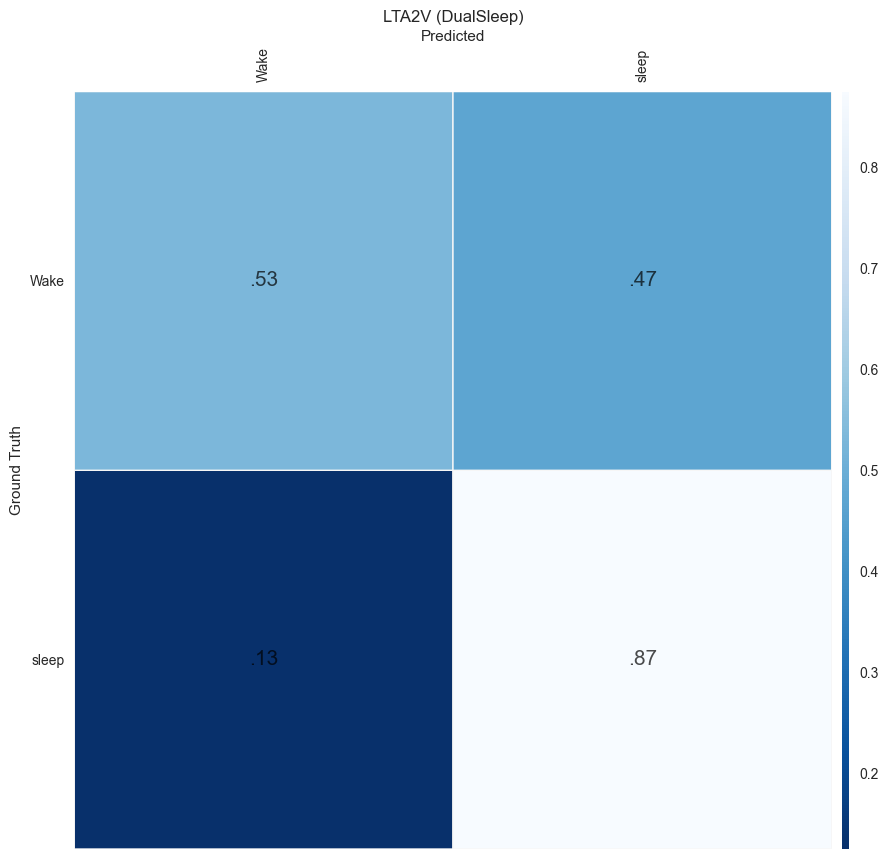

'LTA2V (DualSleep)'

,precision,recall,f1
Wake,0.809003,0.530508,0.640805
N1,0.650739,0.874753,0.746298


In [4]:
summary(res_to_plot, _combine_classes=combine_classes)

## Bar plot for average given metric

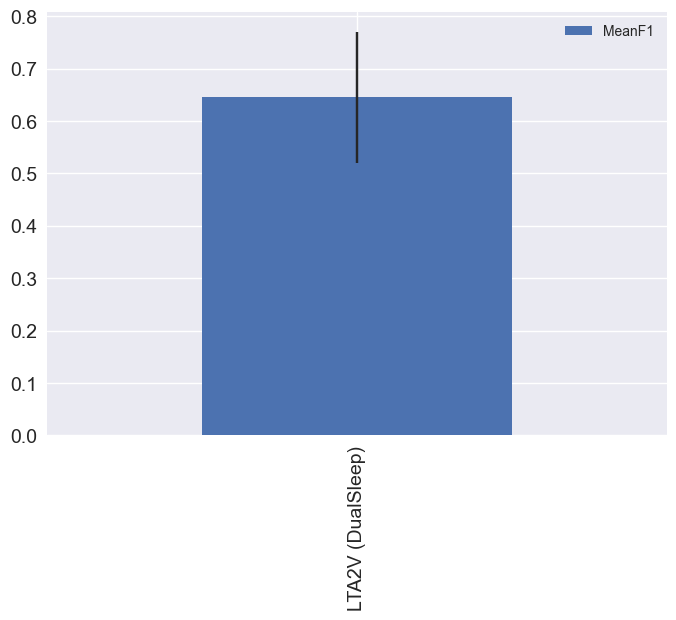

In [5]:
plot_metrics(res_to_plot, metric='F1', _combine_classes=combine_classes)

## Raw results for more details

In [6]:
res, _, act_res, summed_cmats, norm_summed_cmats, _summed_cmats = get_summarized_results(res_to_plot, combined_classes=combine_classes)
res

,LTA2V (DualSleep)
MaxAccuracy,0.937501
MaxF1,0.930380
MaxPrecision,0.929886
MaxSensitivity,0.930881
MeanAccuracy,0.774380
MeanF1,0.645377
MeanPrecision,0.801787
MeanSensitivity,0.670829
MinAccuracy,0.589223
MinF1,0.473625


# Plot downstream 5-fold CV results

## Put here the name of the method, the path to CV_folds5_cmats, and the files used per fold

In [ ]:
res_to_plot = {
    'MonoSelfPAB (USC-HAD)' : {'res_path': 'params/MonoSelfPAB_downstream_experiments/MonoSelfPAB_downstream_uschad/CV_folds5_cmats/',
                               'folds': [['Subject9', 'Subject11', 'Subject7'],['Subject6', 'Subject3', 'Subject4'],['Subject8', 'Subject12', 'Subject1'],['Subject13', 'Subject2', 'Subject14'],['Subject5', 'Subject10']]},
}

In [ ]:
combine_classes = None

In [ ]:
summary(res_to_plot, _combine_classes=combine_classes)

In [ ]:
plot_metrics(res_to_plot, metric='F1', _combine_classes=combine_classes)

In [ ]:
res, _, act_res, summed_cmats, norm_summed_cmats, _summed_cmats = get_summarized_results(res_to_plot, combined_classes=combine_classes)
res